In [1]:
from pathlib import Path
from carps.analysis.gather_data import read_jsonl_content
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn
from omegaconf import OmegaConf
from dacboenv.experiment.collect_incumbents import add_metadata_to_dict
from tqdm import tqdm

setup_seaborn()

log_fn = "DACBOEnvLogs.jsonl"
rundirs = [
    # "../runs_eval/SMAC-AC--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssmart_Repisode_finished_scaled_Ibbob2d_3seeds--seed1",
    # "/scratch/hpc-prf-intexml/tklenke/experiment_runs/dacboenv_ppo_semi/runs/PPO-Perceptron-dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssmart_Repisode_finished_scaled_Ibbob2d_3seeds-1",
    # "/scratch/hpc-prf-intexml/tklenke/experiment_runs/dacboenv_ppo_semi/runs/Random",
    "../runs_statespace"
]
filenames = []
for rundir in rundirs:
    _fns = list(Path(rundir).glob(f"**/{log_fn}"))
    filenames.extend(_fns)

def load_obs(filenames: list[str]) -> tuple[pd.DataFrame, list[str]]:
    observations = []
    for rundir in tqdm(filenames):
        rundir = Path(rundir)
        cfg_fn = rundir.parent / ".hydra/config.yaml"
        cfg = OmegaConf.load(cfg_fn)
        obs = read_jsonl_content(rundir)
        obs_keys = list(obs.iloc[0]["observation"].keys())

        expanded = obs["observation"].apply(pd.Series)
        expanded.columns = obs_keys
        obs = obs.drop(columns="observation").join(expanded)
        policy_id = cfg.policy_id if hasattr(cfg, "policy_id") else rundir.parts[-8]
        obs["policy_id"] = policy_id
        other_cols = [c for c in obs.columns if c not in obs_keys]
        obs = obs.rename(columns={"tsp": "tsd", "tsp_best": "tsd_best"})
        obs_keys = [c for c in obs.columns if c not in other_cols]
        obs = add_metadata_to_dict(obs, cfg)
        observations.append(obs)
    observations = pd.concat(observations).reset_index(drop=True)
    observations["task_id"] = observations["task_id"].map(lambda x: x.replace("bbob", "BBOB"))
    observations["task_id"] = observations["task_id"].map(lambda x: x[:-2] if x.startswith("BBOB") else x)

    return observations, obs_keys

def apply_pca_reduction(obs, obs_keys):
    X = obs[obs_keys].to_numpy()
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    obs["X_pca"] = list(X_pca)
    expanded = obs["X_pca"].apply(pd.Series)
    expanded.columns = [f"x_{i},pca" for i in range(X_pca.shape[-1])]
    return obs.drop(columns="X_pca").join(expanded)


print(len(filenames))
obs, obs_keys = load_obs(filenames)
obs.to_csv("obs.csv", index=False)
pd.Series(obs_keys).to_csv("obs_keys.csv", index=False)



250


100%|██████████| 250/250 [00:24<00:00, 10.23it/s]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from carps.analysis.utils import get_color_palette, savefig, setup_seaborn


setup_seaborn(font_scale=1.1)

def plot_time_progression_quiver(
    obs,
    x_col="x_0,pca",
    y_col="x_1,pca",
    time_col="n_trials",
    policy_col="policy_id",
    figsize=(6, 4),
    point_size=55,
    arrow_width=0.01,
    suffix: str | None = None,
    legend_n_col: int = 1
):
    """Plot time progression using arrows (quiver), per policy.

    - Points show states
    - Arrows point toward the next time step
    - Start marker: hollow circle
    - End marker: X
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    policies = obs[policy_col].unique()
    policy_to_color = get_color_palette(optimizers=policies)

    for (policy_id, seed), g in obs.groupby([policy_col, "seed"]):
        # Sort by time within policy
        g = g.sort_values(time_col)

        x = g[x_col].values
        y = g[y_col].values

        if len(x) < 2:
            continue

        dx = np.diff(x)
        dy = np.diff(y)

        color = policy_to_color[policy_id]

        label = policy_id

        # Scatter points
        ax.scatter(
            x,
            y,
            s=point_size,
            color=color,
            alpha=0.8,
            label=label,
        )

        # Quiver arrows (time direction)
        ax.quiver(
            x[:-1],
            y[:-1],
            dx,
            dy,
            angles="xy",
            scale_units="xy",
            scale=1,
            width=arrow_width,
            color=color,
            alpha=0.5,
        )

        # Start marker
        ax.scatter(
            x[0],
            y[0],
            marker="o",
            s=point_size * 2.2,
            facecolors="none",
            edgecolors=color,
            linewidths=2,
        )

        # End marker
        ax.scatter(
            x[-1],
            y[-1],
            marker="X",
            s=point_size * 2.2,
            color=color,
            linewidths=2,
        )
    xlabel = x_col if x_col != "x_0,pca" else r"$x_{0, \mathrm{PCA}}$"
    ylabel = y_col if y_col != "x_1,pca" else r"$x_{1, \mathrm{PCA}}$"
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title("State Space (PCA(n=2))")
    suffix = suffix if suffix is not None else policy_col
    ax.legend(title=None, bbox_to_anchor=(1.05, 1), ncol=legend_n_col)
    fig.tight_layout()
    savefig(fig=fig, filename=f"figures/state_space/desiderata/{suffix}")
    plt.show()


# for task_id, group in obs.groupby("task_id"):
#     plot_time_progression_quiver(group, task_id, arrow_width=0.004)
#     # break

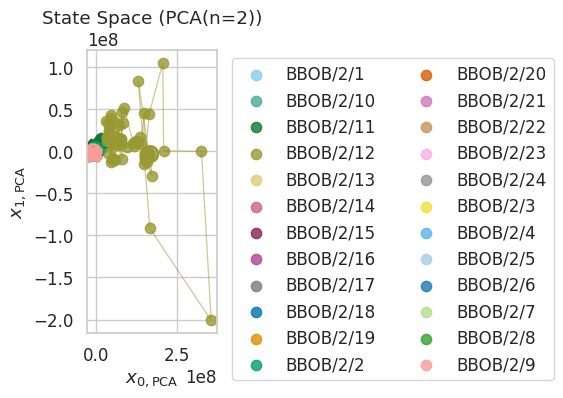

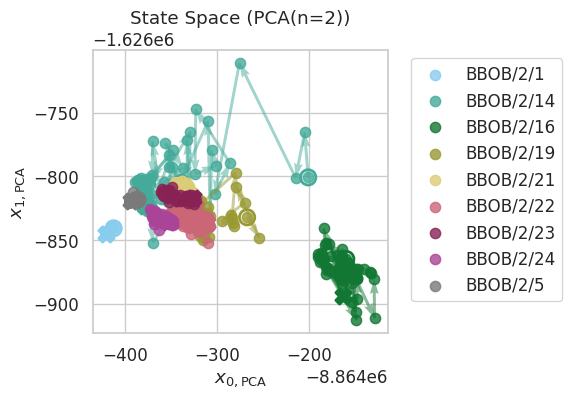

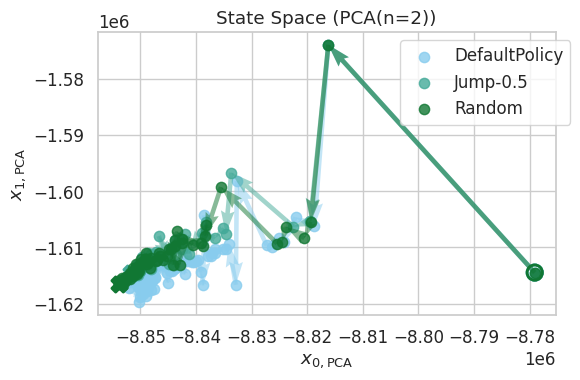

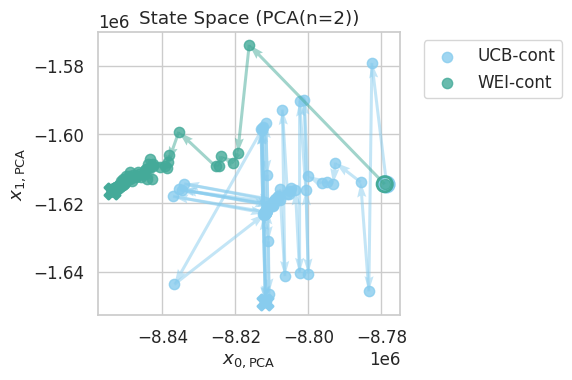

In [3]:

if "x_1,pca" not in obs.columns:
    obs = apply_pca_reduction(obs, obs_keys)


seed = 2

# (1): one optimizer (default), many functions (hue)
group = obs[
    (obs["optimizer_id"] == "NoOpPolicy") & \
    (obs["seed"] == seed) & \
    (obs["action_space_id"] == "WEI-cont")
]
plot_time_progression_quiver(
    group, policy_col="task_id", suffix="diverse_tasks", legend_n_col=2)

group = obs[
    (obs["optimizer_id"] == "NoOpPolicy") & \
    (obs["seed"] == seed) & \
    (obs["task_id"] != "BBOB/2/12") & \
    (obs["task_id"] != "BBOB/2/11") & \
    (obs["task_id"] != "BBOB/2/10") & \
    (obs["task_id"] != "BBOB/2/2") & \
    (obs["task_id"] != "BBOB/2/6") & \
    (obs["task_id"] != "BBOB/2/8") & \
    (obs["task_id"] != "BBOB/2/7") & \
    (obs["task_id"] != "BBOB/2/9") & \
    (obs["task_id"] != "BBOB/2/20") & \
    (obs["task_id"] != "BBOB/2/18") & \
    (obs["task_id"] != "BBOB/2/13") & \
    (obs["task_id"] != "BBOB/2/17") & \
    (obs["task_id"] != "BBOB/2/3") & \
    (obs["task_id"] != "BBOB/2/4") & \
    (obs["task_id"] != "BBOB/2/15") & \
    (obs["action_space_id"] == "WEI-cont")
]
plot_time_progression_quiver(group, policy_col="task_id", suffix="diverse_tasks_reduced")

# (2): one task, many optimizers
task_id = "BBOB/2/20"
group = obs[
    (obs["task_id"] == task_id) & \
    (obs["seed"] == seed) & \
    (obs["action_space_id"] == "WEI-cont")
    # (obs["optimizer_id"] == "Jump-0.5")
]
plot_time_progression_quiver(group)

# (3): one optimizer (default), two action spaces
task_id = "BBOB/2/20"
group = obs[
    (obs["task_id"] == task_id) & \
    (obs["seed"] == seed) & \
    # (obs["action_space_id"] == "") & \
    (obs["optimizer_id"] == "Random")
]
plot_time_progression_quiver(group, policy_col="action_space_id")



Index(['reward', 'n_trials', 'incumbent_changes', 'trials_passed',
       'trials_left', 'ubr', 'searchspace_dim', 'continuous_hps',
       'categorical_hps', 'ordinal_hps', 'int_hps', 'tsd', 'knn_entropy',
       'y_skewness', 'y_kurtosis', 'y_mean', 'y_std', 'y_variability',
       'tsd_best', 'knn_entropy_best', 'y_skewness_best', 'y_kurtosis_best',
       'y_mean_best', 'y_std_best', 'y_variability_best', 'budget_percentage',
       'inc_improvement_scaled', 'has_categorical_hps', 'knn_difference',
       'ubr_difference', 'acq_value_EI', 'acq_value_PI',
       'gp_hp_k1__k1__constant_value0_observation',
       'gp_hp_k1__k2__length_scale0_observation',
       'gp_hp_k1__k2__length_scale1_observation',
       'gp_hp_k2__noise_level0_observation', 'policy_id', 'seed', 'task_id',
       'optimizer_id', 'reward_id', 'action_space_id', 'objective_function',
       'config', 'x_0,pca', 'x_1,pca'],
      dtype='object')


[22:19:12] INFO     Too many optimizers: 24 > 16. Reusing markers.                                      ]8;id=330162;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=882579;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

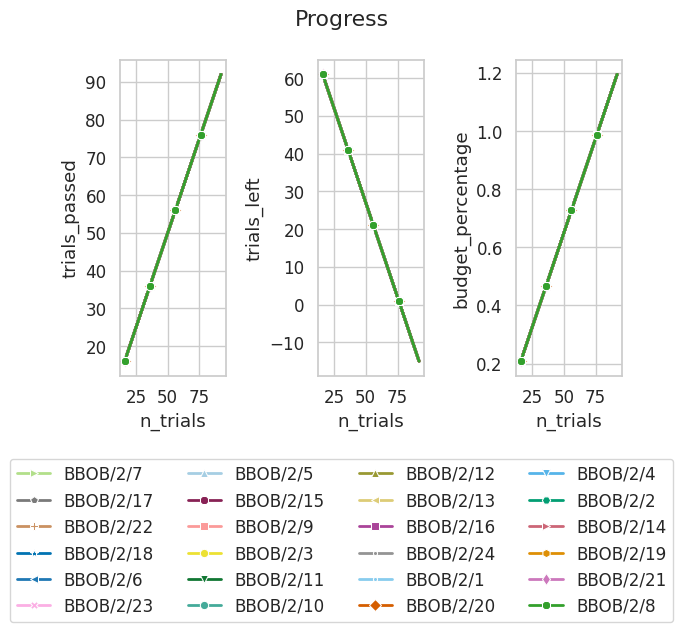

[22:19:14] INFO     Too many optimizers: 24 > 16. Reusing markers.                                      ]8;id=955695;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=502453;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

/tmp/ipykernel_2678043/2023728252.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group[_key] = group.groupby("task_id")[key].transform(lambda x: x / x.min() / (x.max() - x.min()))


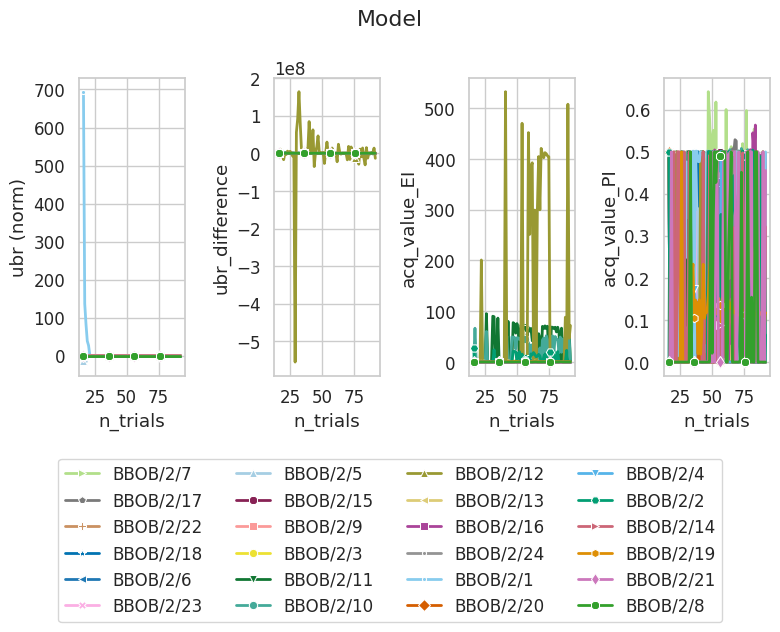

[22:19:16] INFO     Too many optimizers: 24 > 16. Reusing markers.                                      ]8;id=609358;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=343889;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

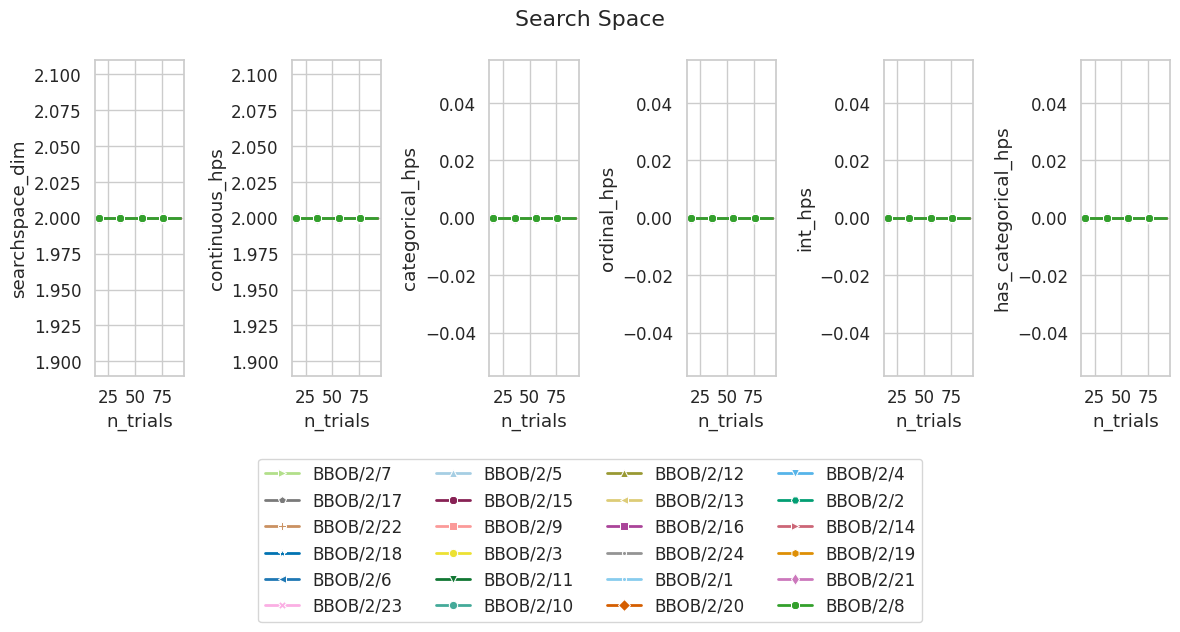

[22:19:19] INFO     Too many optimizers: 24 > 16. Reusing markers.                                      ]8;id=64512;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=493478;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

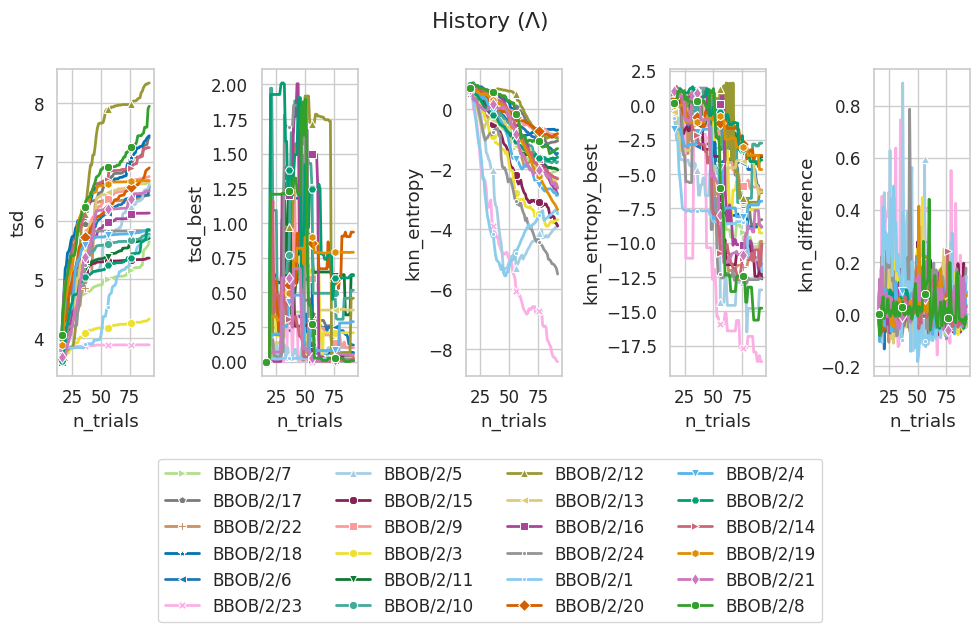

[22:19:21] INFO     Too many optimizers: 24 > 16. Reusing markers.                                      ]8;id=563979;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=67832;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

/tmp/ipykernel_2678043/2023728252.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group[_key] = group.groupby("task_id")[key].transform(lambda x: x / x.min() / (x.max() - x.min()))
/tmp/ipykernel_2678043/2023728252.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group[_key] = group.groupby("task_id")[key].transform(lambda x: x / x.min() / (x.max() - x.min()))
/tmp/ipykernel_2678043/2023728252.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[22:19:23] INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=394166;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=725376;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

           INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=957789;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=395173;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

[22:19:24] INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=275504;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=625016;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

           INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=126352;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=174913;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

[22:19:25] INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=742684;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=404692;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

           INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=13497;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=844217;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

           INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=684892;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=645949;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

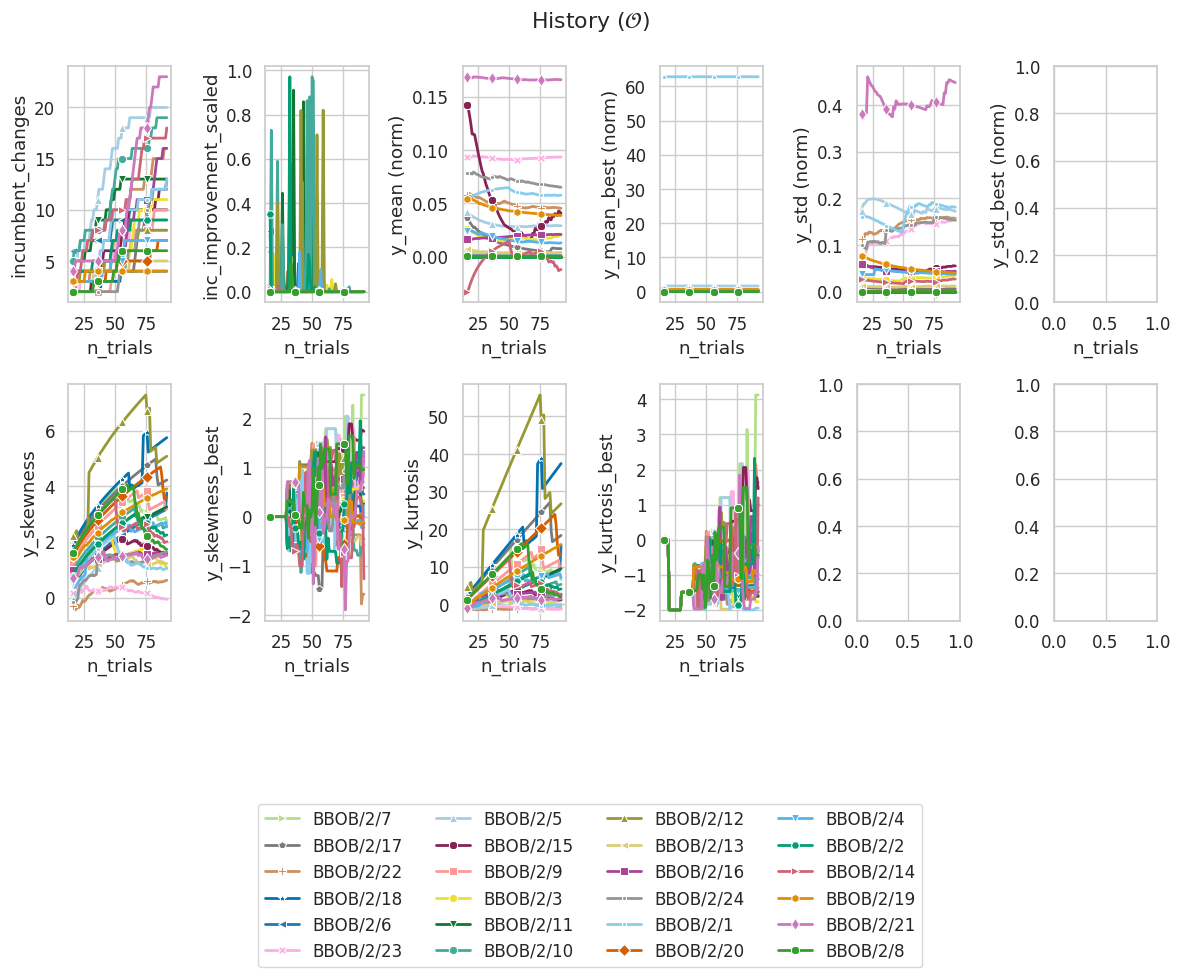

[22:19:26] INFO     Too many optimizers: 24 > 16. Reusing markers.                                      ]8;id=717610;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=202697;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

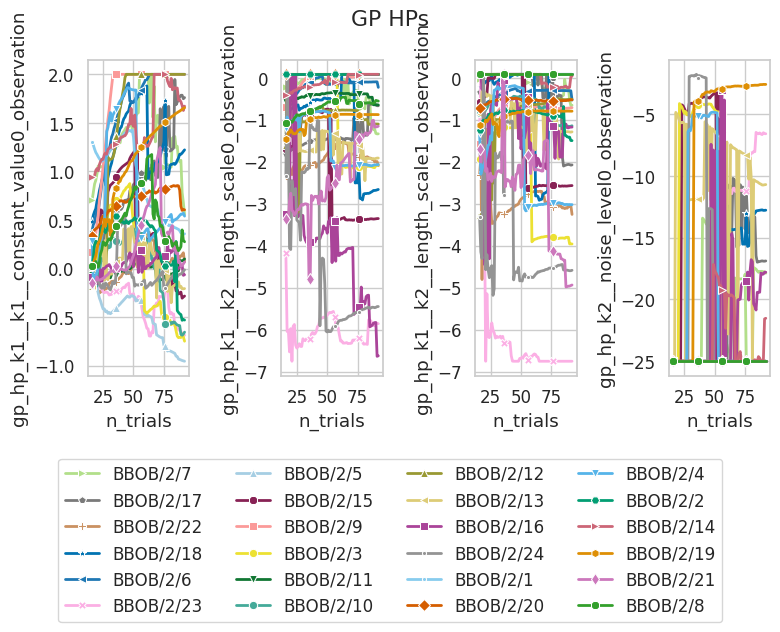

In [6]:
import math
from carps.analysis.utils import setup_seaborn, get_marker_palette, savefig

setup_seaborn(font_scale=1.1)

# (3): single S over time over bbob 20, jump
task_id = "bbob/2/20/0"
group = obs[
    # (obs["task_id"] == task_id) & \
    (obs["seed"] == seed) & \
    (obs["action_space_id"] == "WEI-cont") & \
    (obs["optimizer_id"] == "Jump-0.5")
]
keys_progress = [
    "trials_passed",
    "trials_left",
    "budget_percentage"
]
keys_model = [
    "ubr",
    "ubr_difference",
    "acq_value_EI",
    "acq_value_PI",
]
keys_xhist = [
    "tsd",
    "tsd_best",
    "knn_entropy",
    "knn_entropy_best",
    "knn_difference"
]
keys_yhist = [
    "incumbent_changes",
    "inc_improvement_scaled",
    "y_mean",
    "y_mean_best",
    "y_std",
    "y_std_best",
    "y_skewness",
    "y_skewness_best",
    "y_kurtosis",
    "y_kurtosis_best",
    # "y_variability",
    # "y_variability_best",
]
keys_gp = [
 "gp_hp_k1__k1__constant_value0_observation",
 "gp_hp_k1__k2__length_scale0_observation",
 "gp_hp_k1__k2__length_scale1_observation",
 "gp_hp_k2__noise_level0_observation",
]
keys_search_space = [
    "searchspace_dim",
    "continuous_hps",
    "categorical_hps",
    "ordinal_hps",
    "int_hps",
    "has_categorical_hps"
]
# assert len(obs_keys) == len(keys_progress + keys_search_space + keys_model + keys_xhist + keys_yhist + keys_gp)

def plot_states(group, keys, title, cols_max=4):
    ncols = min(cols_max, len(keys))
    nrows = math.ceil(len(keys) / ncols)
    axwidth = 2
    axheight = 2.5
    legendspace = 2
    fig = plt.figure(figsize=(axwidth * ncols, axheight * nrows + legendspace))
    axes = fig.subplots(ncols=ncols, nrows=nrows)
    task_ids = list(group["task_id"].unique())
    palette = get_color_palette(optimizers=task_ids)
    marker_palette = get_marker_palette(optimizers=task_ids)
    for i, key in enumerate(keys):
        _key = key
        if key in ["ubr", "y_mean", "y_mean_best", "y_std", "y_std_best"]:
            _key = key + " (norm)"
            group[_key] = group.groupby("task_id")[key].transform(lambda x: x / x.min() / (x.max() - x.min()))
        ax = axes.flat[i]
        ax = sns.lineplot(
            data=group,
            x="n_trials",
            y=_key,
            hue="task_id",
            palette=palette,
            ax=ax,
            linewidth=2,
            style="task_id",
            dashes=False,
            markers=marker_palette,
            markevery=20
        )
        ax.legend().remove()

    legend = ax.legend()
    fig.suptitle(title)
    fig.legend(
        handles=legend.legend_handles,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.4),
        ncols=4,
    )
    legend.remove()
    fig.tight_layout()
    savefig(fig=fig, filename=f"figures/state_space/single/{title}")
    plt.show()

cols_max = 6
print(group.columns)
plot_states(group, keys_progress, "Progress", cols_max=cols_max)
plot_states(group, keys_model, "Model", cols_max=cols_max)
plot_states(group, keys_search_space, "Search Space", cols_max=cols_max)
plot_states(group, keys_xhist, "History ($\\Lambda$)", cols_max=cols_max)
plot_states(group, keys_yhist, "History ($\\mathcal{O}$)", cols_max=cols_max)
plot_states(group, keys_gp, "GP HPs", cols_max=cols_max)


/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1079396/2725494789.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  adjustment = delta_alpha * np.tanh(k * (-_v_pi + _v_ei)) * np.exp(-r ** 2 / sigma_r ** 2)


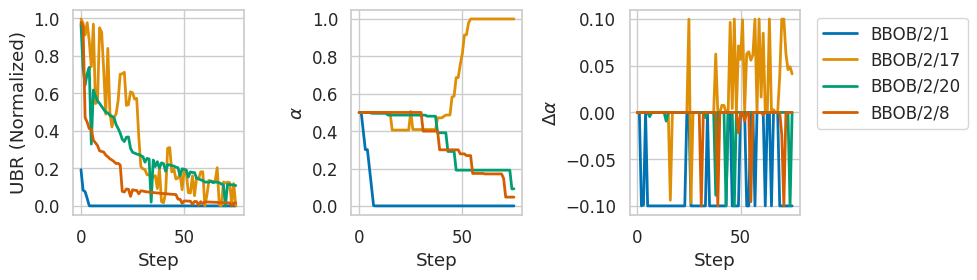

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from carps.analysis.utils import setup_seaborn, savefig

setup_seaborn(font_scale=1.1)

task_id = "BBOB/2/8"
seed = 3
group = obs[
    # (obs["task_id"] == task_id) & \
    (obs["task_id"].isin(["BBOB/2/1", "BBOB/2/8", "BBOB/2/17", "BBOB/2/20"])) & \
    (obs["seed"] == seed) & \
    (obs["action_space_id"] == "WEI-cont") & \
    (obs["optimizer_id"] == "NoOpPolicy")
]


delta_alpha = 0.1

k = 100

res = []
for task_id, gdf in group.groupby("task_id"):
    previous_alpha = 0.5
    ubr = gdf["ubr"].to_numpy()
    ubr_diff = np.diff(ubr)
    v_ei = gdf["acq_value_EI"].to_numpy()
    v_pi = gdf["acq_value_PI"].to_numpy()
    ubr_max = ubr.max()
    ubr_min = ubr.min()
    ubr_norm = (ubr - ubr_min) / (ubr_max - ubr_min)
    ubr_norm = ubr_norm[1:]

    alphas = []
    adjustments = []
    for step in range(len(ubr_diff)):
        sigma_r = np.std(ubr_diff[:step])
        if np.isnan(sigma_r):
            sigma_r = 1
        r = ubr_diff[step]
        _v_ei = v_ei[step]
        _v_pi = v_pi[step]

        adjustment = delta_alpha * np.tanh(k * (-_v_pi + _v_ei)) * np.exp(-r ** 2 / sigma_r ** 2)
        alpha = previous_alpha + adjustment

        alpha_clipped = max(0, min(1, alpha))
        alphas.append(alpha_clipped)
        previous_alpha = alpha_clipped
        adjustments.append(adjustment)
    res.append(pd.DataFrame({
        "step": np.arange(0, len(alphas)),
        "alpha": alphas,
        "task_id": task_id,
        "seed": seed,
        "adjustment": adjustments,
        "ubr_norm": ubr_norm,
    }))
res = pd.concat(res).reset_index(drop=True)

fig = plt.figure(figsize=(10,3))
axes = fig.subplots(nrows=1, ncols=3, sharex=True, sharey=False)

ax = axes[0]
ax = sns.lineplot(data=res, x="step", y="ubr_norm", hue="task_id", ax = ax, linewidth=2)
ax.set_xlabel("Step")
ax.set_ylabel("UBR (Normalized)")
ax.legend(title=None).remove()

ax = axes[1]
ax = sns.lineplot(data=res, x="step", y="alpha", hue="task_id", ax = ax, linewidth=2)
ax.set_xlabel("Step")
ax.set_ylabel("$\\alpha$")
ax.legend(title=None).remove()

ax = axes[2]
ax = sns.lineplot(data=res, x="step", y="adjustment", hue="task_id", ax =ax, linewidth=2)
ax.set_xlabel("Step")
ax.set_ylabel("$\\Delta\\alpha$")
ax.legend(title=None, bbox_to_anchor=(1.05, 1))
fig.tight_layout()
savefig(fig=fig, filename="figures/dacbo/analytical_sawei")
plt.show()



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

class AlphaRuleNetDynamicR(nn.Module):
    def __init__(self, delta_alpha=0.1, k=10.0):
        super().__init__()
        self.delta_alpha = delta_alpha
        self.k = k

        # 5 inputs now (R_scale is dynamic)
        self.fc1 = nn.Linear(5, 8)
        self.fc2 = nn.Linear(8, 1)

        # Preinitialize output bias to 0
        nn.init.constant_(self.fc2.bias, 0.0)

        # Preinitialize hidden layer weights roughly (as before)
        self.fc1.weight.data.zero_()
        self.fc1.bias.data.zero_()
        # Neurons 0-3 approximate tanh(k*(v_PI - v_EI))
        self.fc1.weight.data[0,1] = k
        self.fc1.weight.data[1,2] = -k
        self.fc1.weight.data[2,1] = 0.5*k
        self.fc1.weight.data[2,2] = -0.5*k
        self.fc1.weight.data[3,1] = 0.5*k
        self.fc1.weight.data[3,2] = -0.5*k
        # Neurons 4-7 approximate Gaussian gate using R / R_scale
        self.fc1.weight.data[4,0] = -1.0  # R coefficient
        self.fc1.weight.data[4,4] = 1.0   # R_scale coefficient
        self.fc1.weight.data[5,0] = 1.0
        self.fc1.weight.data[5,4] = -1.0
        self.fc1.weight.data[6,0] = -0.5
        self.fc1.weight.data[6,4] = 0.5
        self.fc1.weight.data[7,0] = 0.5
        self.fc1.weight.data[7,4] = -0.5

        # Output weights
        self.fc2.weight.data.fill_(delta_alpha * 0.125)

    def forward(self, x):
        R = x[:,0:1]
        v_PI = x[:,1:2]
        v_EI = x[:,2:3]
        alpha_prev = x[:,3:4]
        R_scale = x[:,4:5]

        # Hidden layer
        h = torch.tanh(self.fc1(x))

        # Linear output
        delta_alpha_out = self.fc2(h)

        # Update alpha
        alpha_new = alpha_prev + delta_alpha_out
        alpha_new = torch.clamp(alpha_new, 0.0, 1.0)
        return alpha_new

net = AlphaRuleNetDynamicR()
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of adjustable (trainable) parameters:", num_params)

task_id = "bbob/2/8/0"
seed = 3
group = obs[
    # (obs["task_id"] == task_id) & \
    (obs["seed"] == seed) & \
    (obs["action_space_id"] == "WEI-cont") & \
    (obs["optimizer_id"] == "Jump-0.5")
]


delta_alpha = 0.1
previous_alpha = 0.5
k = 100

res = []
for task_id, gdf in group.groupby("task_id"):
    ubr = gdf["ubr"].to_numpy()
    ubr_diff = np.diff(ubr)
    v_ei = gdf["acq_value_EI"].to_numpy()
    v_pi = gdf["acq_value_PI"].to_numpy()

    alphas = []
    net = AlphaRuleNetDynamicR()
    for step in range(len(ubr_diff)):
        sigma_r = np.std(ubr_diff[:step])
        if np.isnan(sigma_r):
            sigma_r = 1
        r = ubr_diff[step]
        _v_ei = v_ei[step]
        _v_pi = v_pi[step]

        x = torch.tensor([[r, _v_pi, _v_ei, previous_alpha, sigma_r]], dtype=torch.float32)  # R, v_PI, v_EI, alpha_prev, R_scale
        alpha = float(torch.squeeze(net(x).detach()))
        previous_alpha = alpha
        alphas.append(alpha)
    res.append(pd.DataFrame({
        "step": np.arange(0, len(alphas)),
        "alpha": alphas,
        "task_id": task_id,
        "seed": seed
    }))
res = pd.concat(res).reset_index(drop=True)

sns.lineplot(data=res, x="step", y="alpha", hue="task_id")



Number of adjustable (trainable) parameters: 57


NameError: name 'obs' is not defined

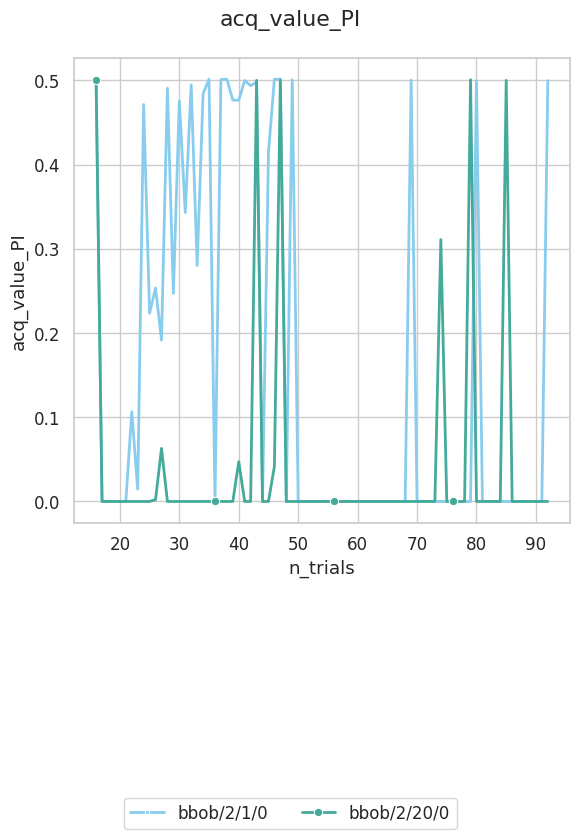

In [ ]:
def plot_state(group, keys, title, cols_max=4):
    ncols = min(cols_max, len(keys))
    nrows = math.ceil(len(keys) / ncols)
    axwidth = 6
    axheight = 4
    legendspace = 2
    fig = plt.figure(figsize=(axwidth * ncols, axheight * nrows + legendspace))
    axes = fig.subplots(ncols=ncols, nrows=nrows)
    task_ids = list(group["task_id"].unique())
    palette = get_color_palette(optimizers=task_ids)
    marker_palette = get_marker_palette(optimizers=task_ids)
    for i, key in enumerate(keys):
        if len(keys) == 1:
            ax = axes
        else:
            ax = axes.flat[i]
        ax = sns.lineplot(
            data=group,
            x="n_trials",
            y=key,
            hue="task_id",
            palette=palette,
            ax=ax,
            linewidth=2,
            style="task_id",
            dashes=False,
            markers=marker_palette,
            markevery=20
        )
        ax.legend().remove()

    legend = ax.legend()
    fig.suptitle(title)
    fig.legend(
        handles=legend.legend_handles,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.4),
        ncols=4,
    )
    legend.remove()
    fig.tight_layout()
    # savefig(fig=fig, filename=f"figures/state_space/single/{title}") 
    plt.show()

plot_state(group[
    group["task_id"].isin(["bbob/2/1/0", "bbob/2/20/0"])
], keys=["acq_value_PI"], title="acq_value_PI")

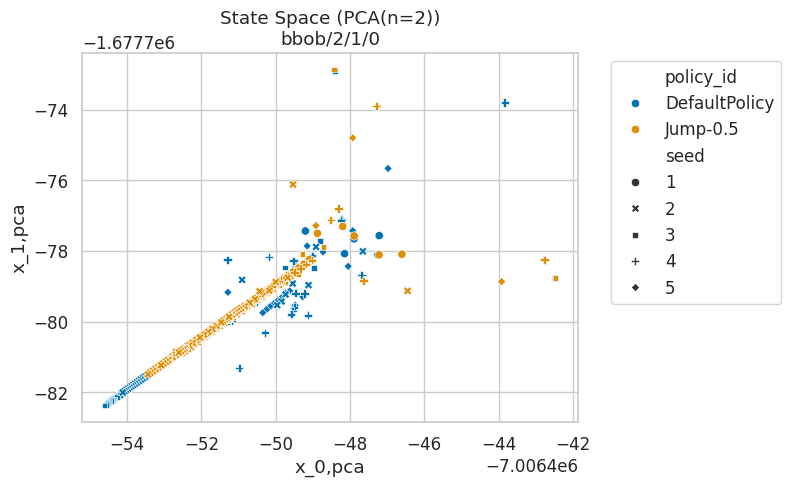

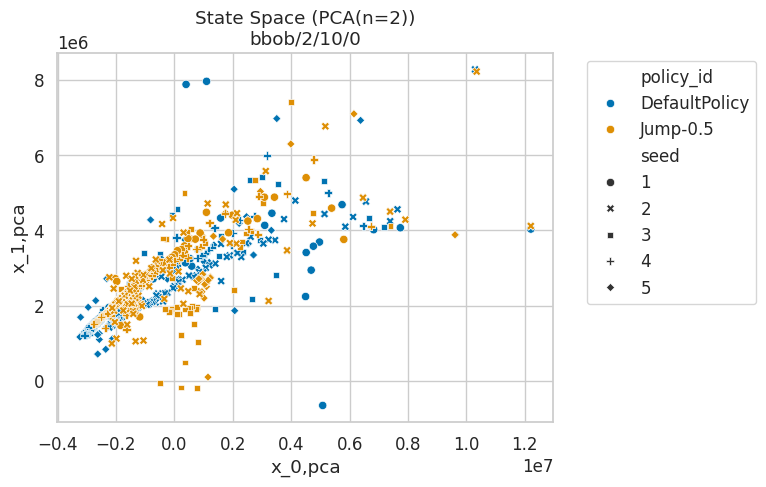

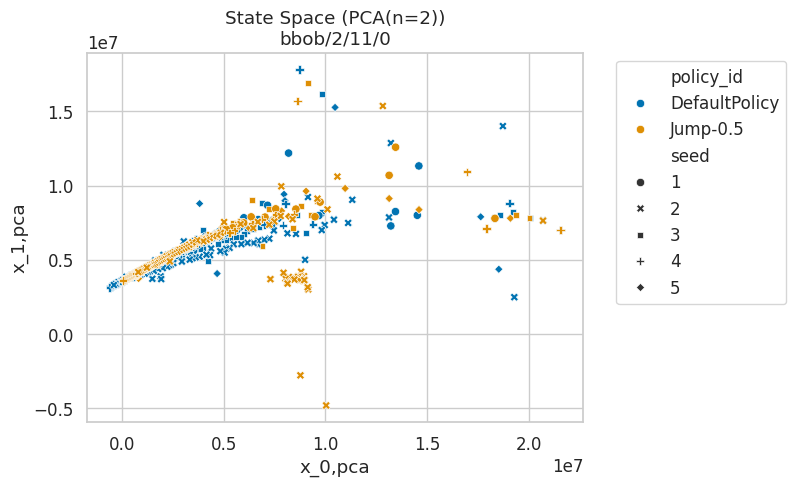

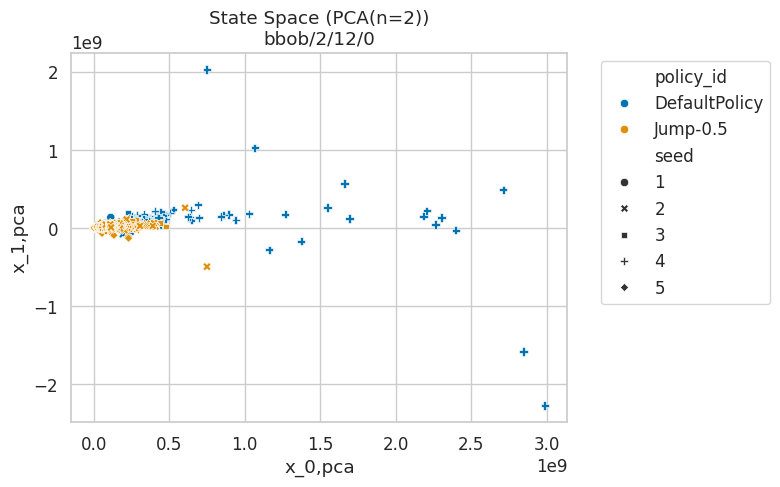

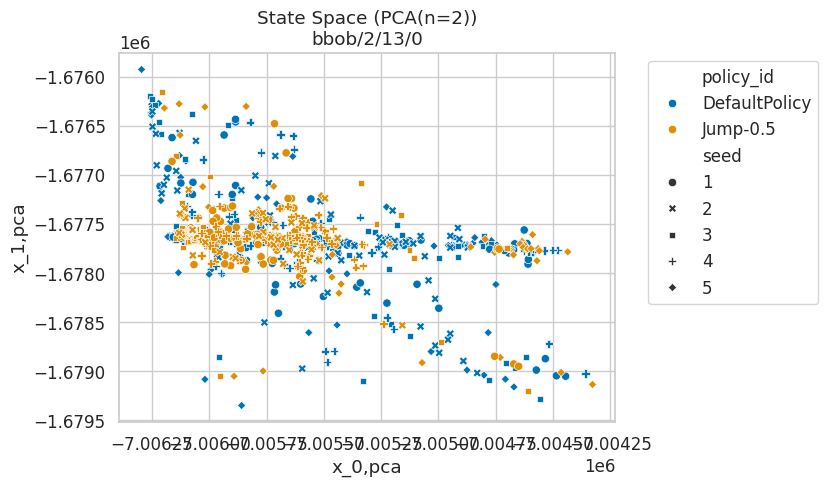

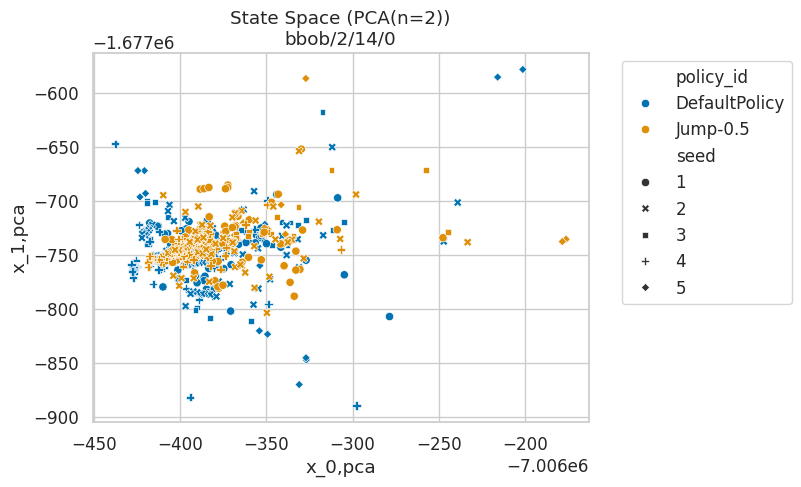

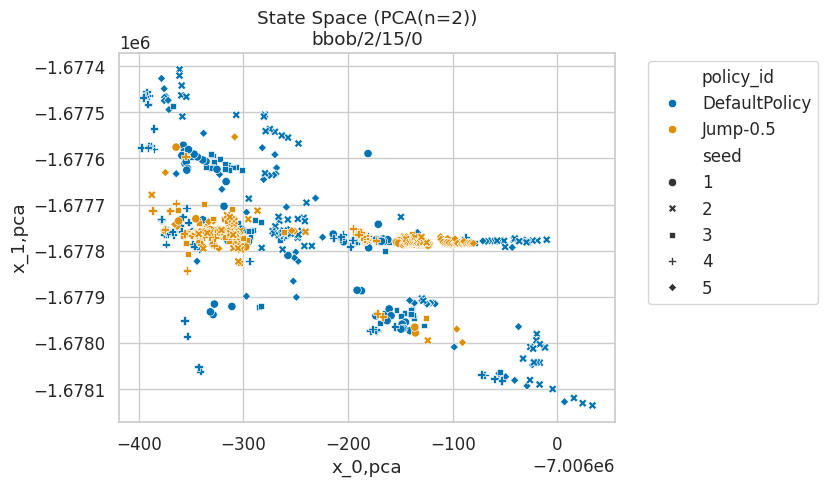

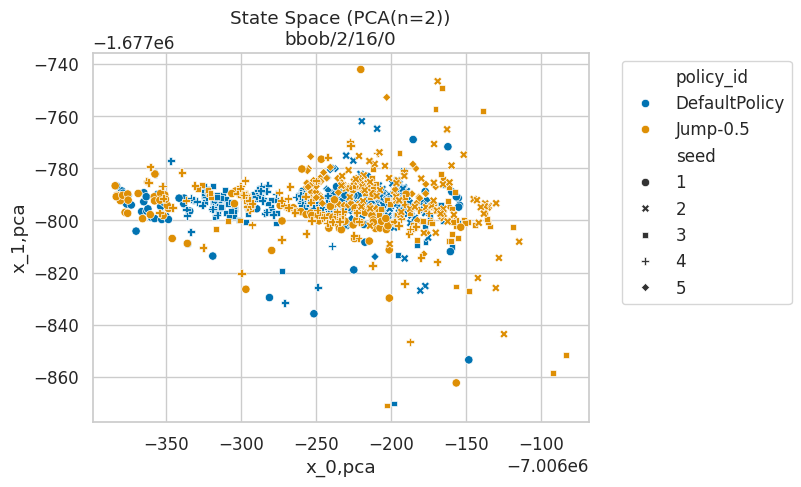

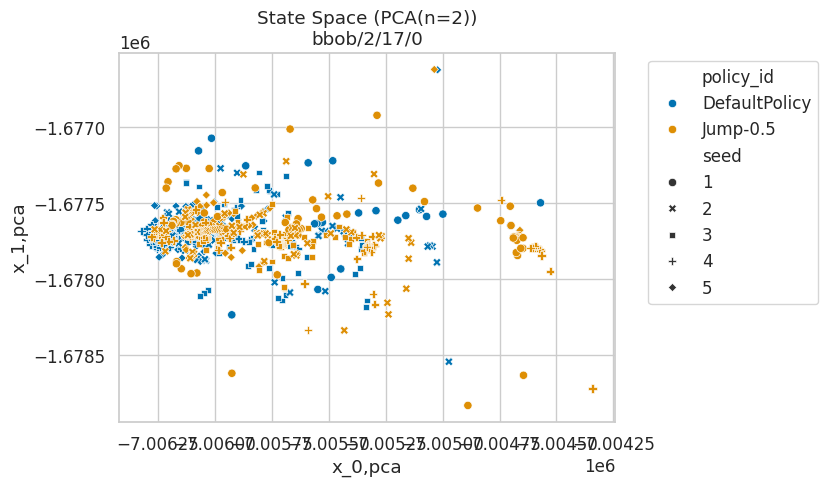

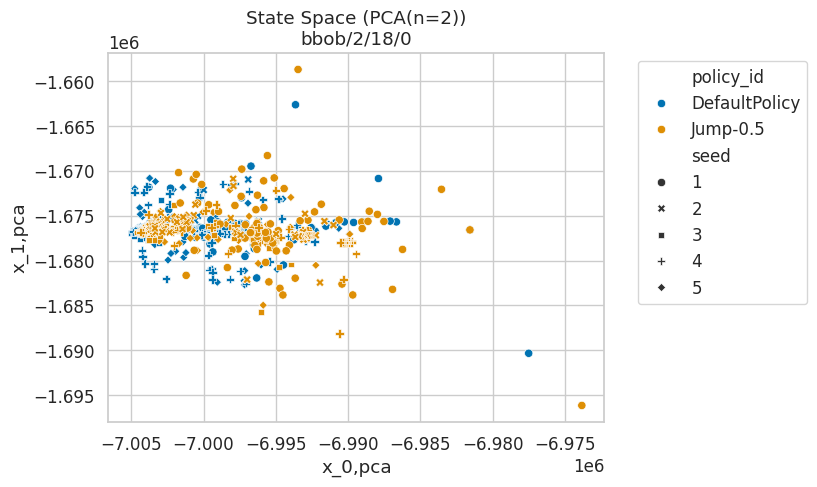

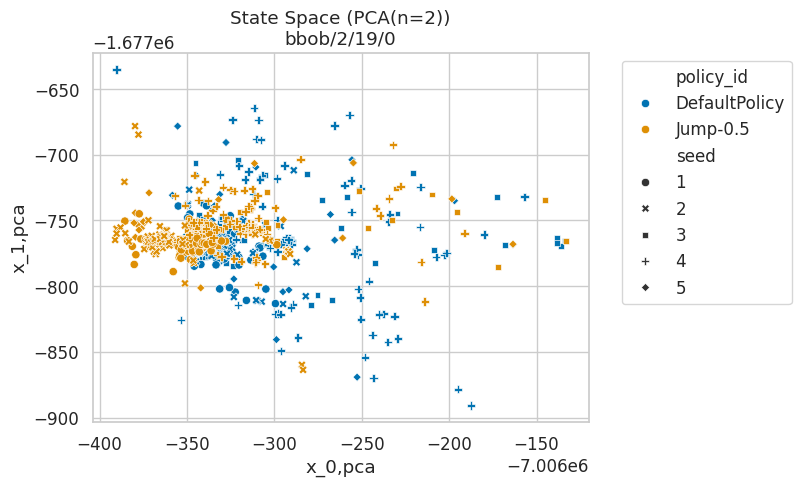

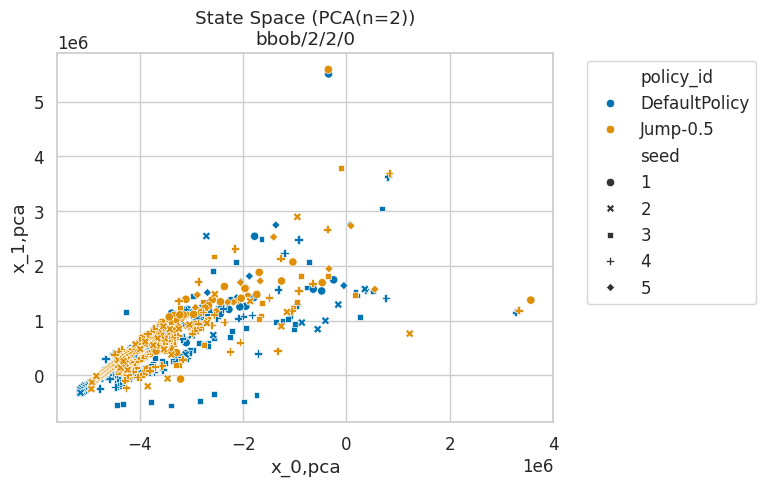

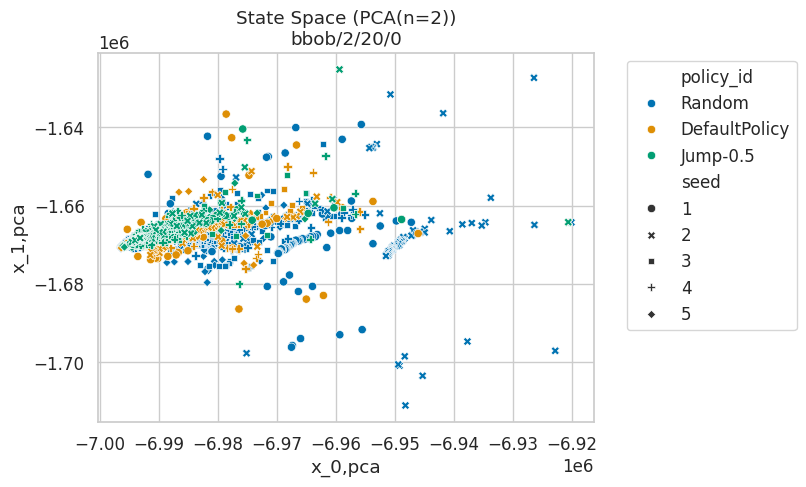

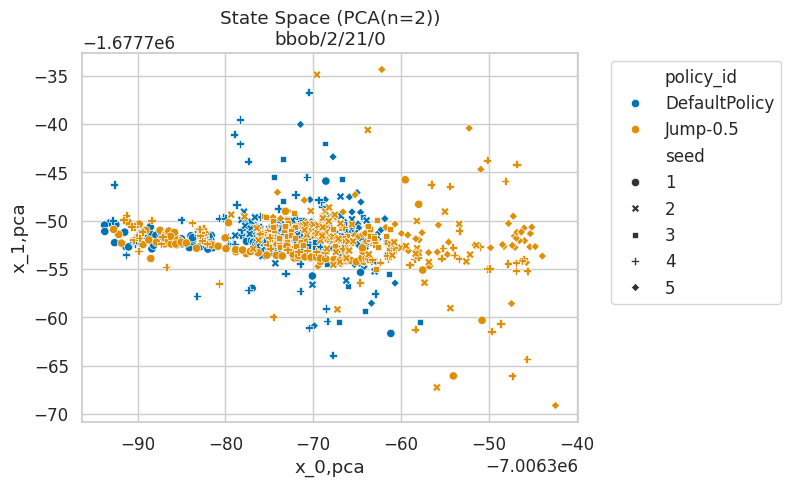

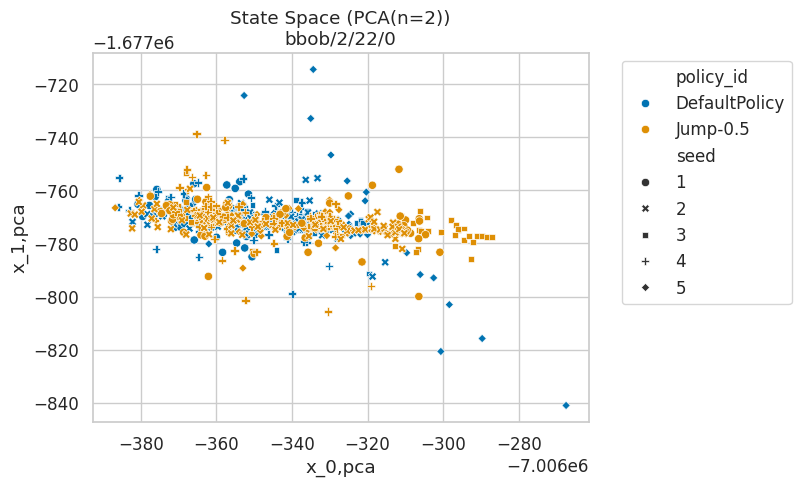

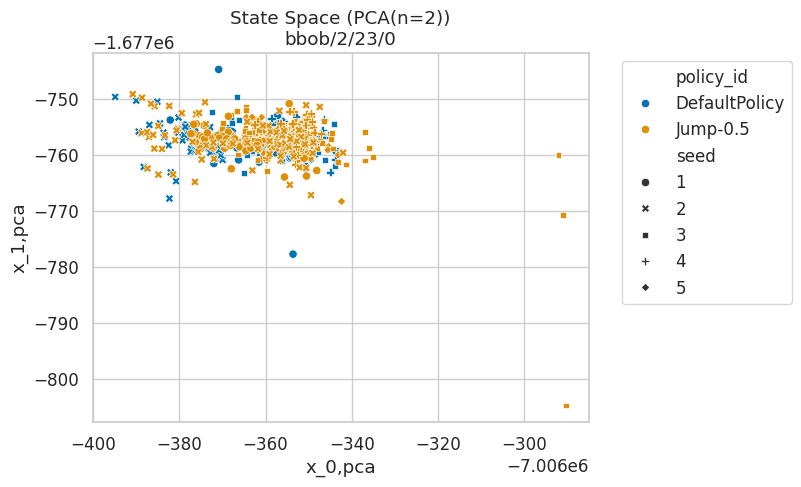

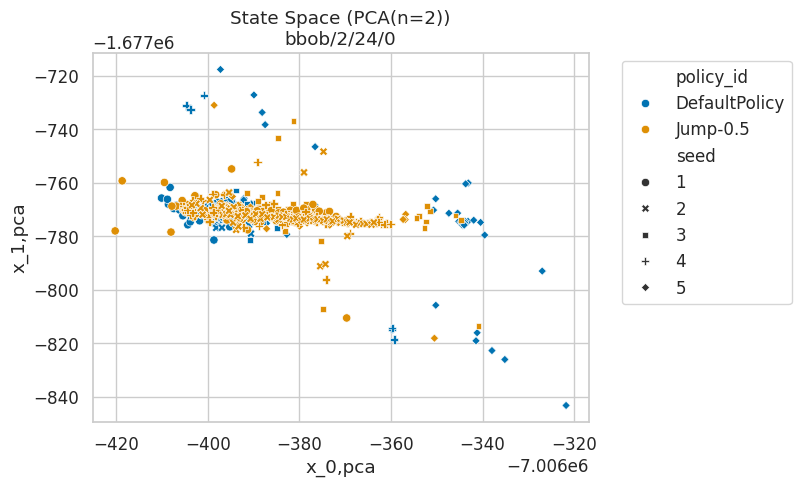

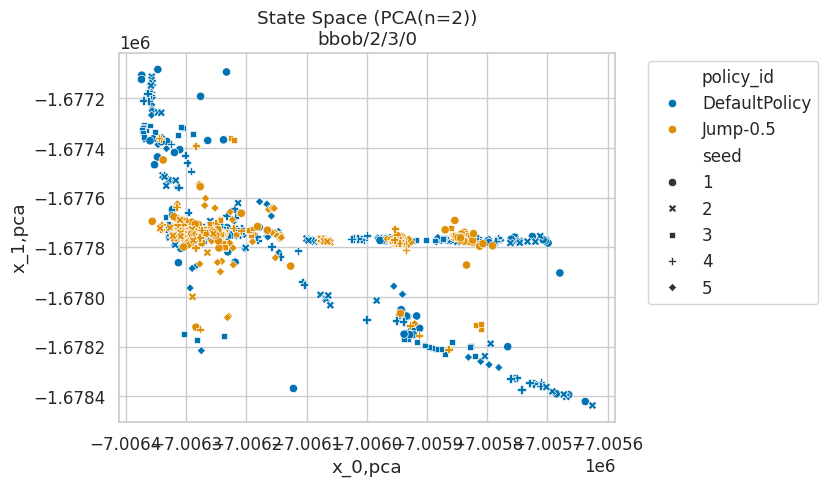

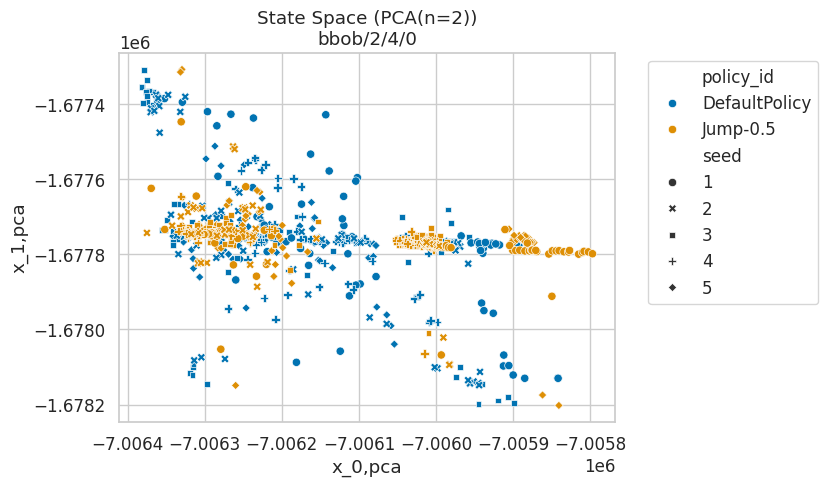

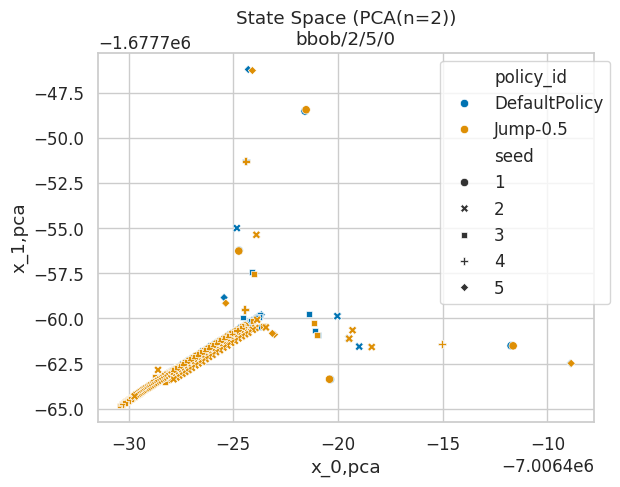

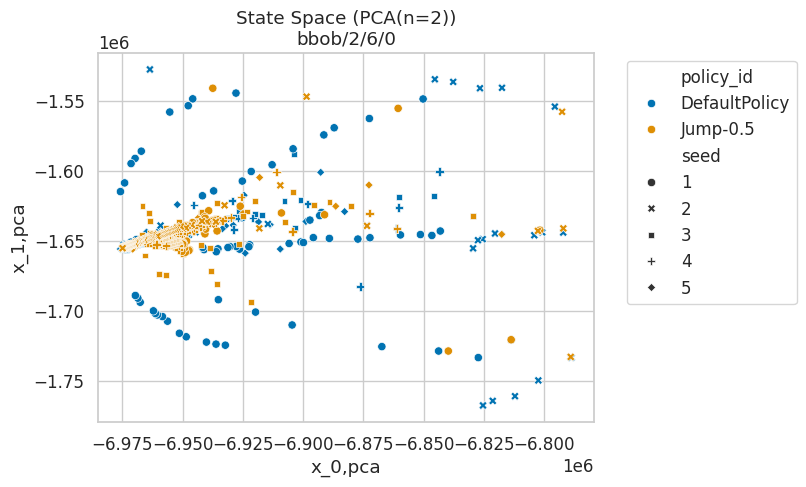

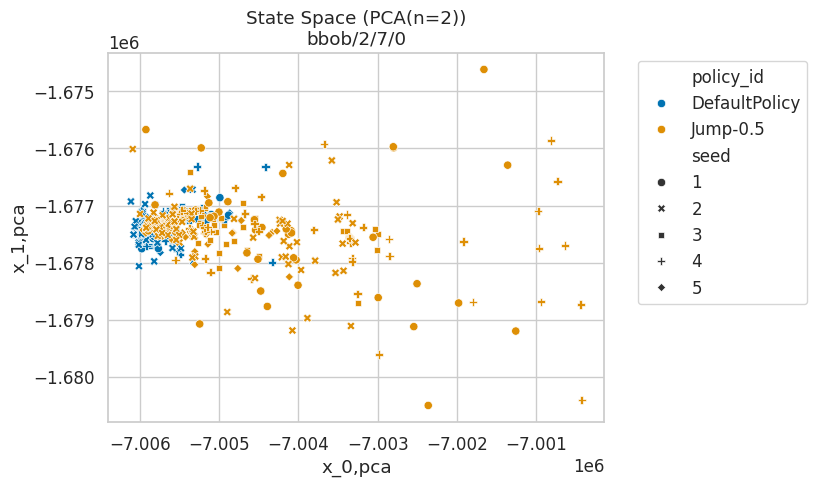

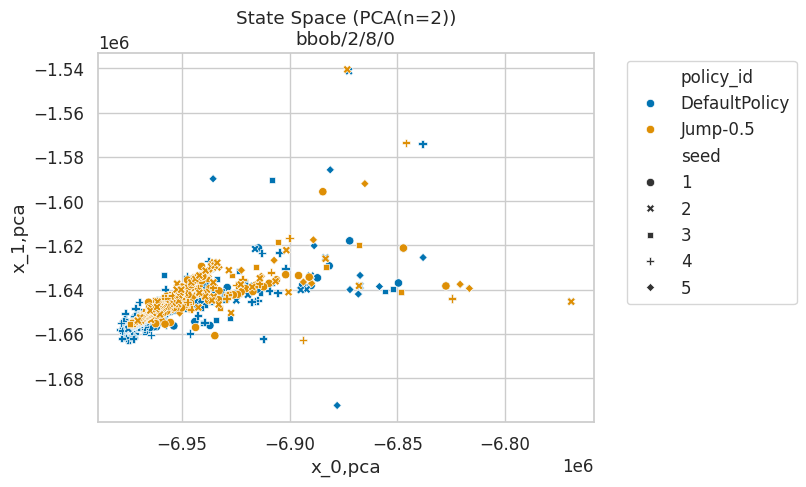

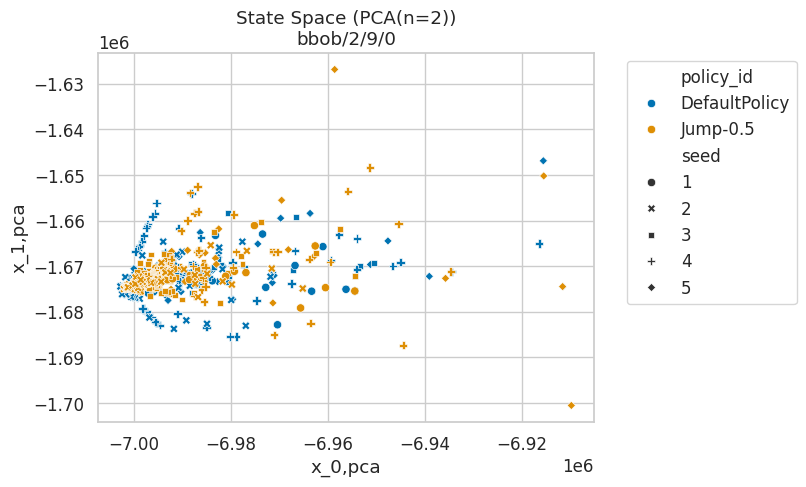

In [61]:

if "x_1,pca" not in obs.columns:
    obs = apply_pca_reduction(obs, obs_keys)

for task_id, group in obs.groupby("task_id"):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax = sns.scatterplot(
        data=group,
        x="x_0,pca",
        y="x_1,pca",
        hue="policy_id",
        style="seed"
    )

    ax.set_title(f"State Space (PCA(n=2))\n{task_id}")
    ax.legend(bbox_to_anchor=(1.05, 1))
    plt.show()
